<h1><center>Hito 12</center></h1>

<h1><center>Temporal decorrelation in audio signals</center></h1>

&nbsp;

<center>
Álvaro Garcı́a Garcı́a<br>
Álvaro José Martı́nez Sánchez<br>
José Francisco Castillo Berenguel<br>
</center>
    
    
<hr style="border:1px solid gray"> </hr>


# Introducción

En el hito 8 se presentó el problema del bitrate, el cual se ha ido sufragando mediante la reducción de los tamaños de los paquetes. La primera opción consistió en comprimir los paquetes mediante zlib, pero no resultó ser suficiente. Mediante la cuantificación, se pudo reducir notoriamente el tamaño de los paquetes a costa de reducir la calidad del audio. El siguiente paso consistió en separar los canales en bandas con el fin de eliminar la correlación espacial y mejorar el ratio de compresión al separar los valores en rangos dinámicos diferentes.

En este hito no solo se se dispone a mejorar la compresión, sino a mitigar los efectos del ruido producido por la cuantificación, minimazndo parcialmente los valores del RMSE, característica que solo podía reducirse mediante el valor del paso de cuantificación. Para este propósito, se aplicará la teoria de la wavelet con el fin de eliminar la correlación temporal. 




# Fundamentos

La decorrelacion temporal se llevará a cabo por medio de la transformada de wavelet, la cual se aplica a cada canal obtenido en la MST (realmente 2 según la transformación lineal).


## Transformada de Wavelet Discreta (DWT)

Dado que los chunks de audio se extraen de forma discretizada, se debe aplicar la transformada de wavelet discreta. La implementación de la DWT se aplicará mediante el paquete `pywt`, el cual dispone de las familias de wavelets:

- Haar (haar)
- Daubechies (dbX)
- Symlet (symX)
- Coiflets (coifX)
- Biorthogonal (biorX)
- Reverse Biorthogonal (rbioX)


Para crear una wavelet de debe identificar mediante su nombre de la forma `pywt.Wavelet(wavelet_name)`. Una vez se tiene la wavelet se puede aplicar la transofmrada mediante `pywt.wavedec(range, wavelet, level, mode)`. Sin embargo, dado que se quiere enviar mediante un vector de enteros, se debe convertir los coeficientes a un vector mediante `pywt.coeffs_to_array()` y aproximarlos al entero más próximo mediante `np.rint(coefs).astype(np.int32)`. Se recuerda que dado que el rango dinámico puede ser puntualmente excesivo, se realizó una expansión a 32 bits.

Para deshacer la wavelet se aplica `pywt.array_to_coeffs(coefs, slices, output_format="wavedec")`. El parámetro `slices` se devuelve al pasar los coeficientes de la descomposición, el cual es necesario para rearmar la descomposición de la wavelet y poder deshacerla. Finalmente se aplica  `np.rint(pywt.waverec(decomposition wavelet, mode)).astype(np.int32)`


## Proceso de aplicación

¿Dónde se aplia la wavelet?

El orden de aplicación (pack) consiste en:

1\. Aplicar la MST y separar en bandas.

2\. Aplicar la DWT y obtener los coeficientes de cada banda.

3\. Aplicar la cuantificación a los coeficientes de la wavelet.

4\. Comprimir.


Para desempaquetar la  secuencia de pasos es:

1\. Descomprimir.

2\. Aplicar decuantificación.

3\. Deshacer la wavelet.

4\. Deshacer la MST.


In [1]:
# Importamos los paquetes necesarios

import sounddevice as sd
import pywt
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pylab
import zlib
import struct

Podemos obtener información de la wavelet

In [2]:
name = "sym8"
print(pywt.Wavelet(name))

Wavelet sym8
  Family name:    Symlets
  Short name:     sym
  Filters length: 16
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       near symmetric
  DWT:            True
  CWT:            False


In [3]:
def plot(y, xlabel='', ylabel='', title='', marker='.'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    x = np.linspace(0, len(y)-1, num=len(y))
    ax.plot(x, y, marker, markersize=1)
    plt.show(block=False)
    
scatter_size = 220

In [336]:
# Grabamos X segunos de audio
X = 3

fs = 44100
duration = X  # seconds
signal = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")
signal_flatten = signal.flatten()

Say something!
done


In [341]:
# En caso de querer guardar el audio
#signal.tofile("audio2.dat")

In [4]:
# En caso de querer cargar un fichero de audio existente
#signal=np.fromfile("audio.dat", dtype=np.int16)
#signal=signal.reshape(int(len(signal)/2), 2)

In [337]:
# Reproducimos el audio 
sd.play(signal)

In [5]:
# Codigos del nucleo de los hitos 10, 11 y 12

def compress(data):
    channel_0 = data[:, 0].copy()
    channel_1 = data[:, 1].copy()
    compressed_channel_0 = zlib.compress(channel_0)
    compressed_channel_1 = zlib.compress(channel_1)
    chunk_number=1000
    packed_chunk = struct.pack("!HH", chunk_number, 1) + compressed_channel_0 + compressed_channel_1
    return packed_chunk

def unpack(packed_chunk, dtype=np.int16):
    (chunk_number, len_compressed_channel_0) = struct.unpack("!HH", packed_chunk[:4])
    compressed_channel_0 = packed_chunk[4:len_compressed_channel_0+4]
    compressed_channel_1 = packed_chunk[len_compressed_channel_0+4:]
    channel_0 = zlib.decompress(compressed_channel_0)
    channel_0 = np.frombuffer(channel_0, dtype)
    channel_1 = zlib.decompress(compressed_channel_1)
    channel_1 = np.frombuffer(channel_1, dtype)
    chunk = np.empty((minimal.args.frames_per_chunk, 2), dtype=dtype)
    chunk[:, 0] = channel_0[:]
    chunk[:, 1] = channel_1[:]
    return chunk_number, chunk

def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int32)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

def MST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = x[:, 0].astype(np.int32) + x[:, 1] # L(ow frequency subband)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1] # H(igh frequency subband)
    return w

def MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = (w[:, 0] + w[:, 1])/2 # L(ow frequency subband)
    x[:, 1] = (w[:, 0] - w[:, 1])/2 # H(igh frequency subband)
    return x

def DWT_analyze(x, levels, wavelet_name):
    coefs = np.empty(x.shape, dtype=np.int32)
    wavelet = pywt.Wavelet(wavelet_name)
    decomposition_0 = pywt.wavedec(x[:, 0], wavelet=wavelet, level=levels, mode="per")
    decomposition_1 = pywt.wavedec(x[:, 1], wavelet=wavelet, level=levels, mode="per")
    coefs_0, slices = pywt.coeffs_to_array(decomposition_0)
    coefs_1, slices = pywt.coeffs_to_array(decomposition_1)
    coefs[:, 0] = np.rint(coefs_0).astype(np.int32)
    coefs[:, 1] = np.rint(coefs_1).astype(np.int32)
    return coefs, slices

def DWT_synthesize(coefs, slices, wavelet_name):
    wavelet = pywt.Wavelet(wavelet_name)
    samples = np.empty(coefs.shape, dtype=np.int16)
    decomposition_0 = pywt.array_to_coeffs(coefs[:, 0], slices, output_format="wavedec")
    decomposition_1 = pywt.array_to_coeffs(coefs[:, 1], slices, output_format="wavedec")
    samples[:, 0] = np.rint(pywt.waverec(decomposition_0, wavelet=wavelet, mode="per")).astype(np.int32)
    samples[:, 1] = np.rint(pywt.waverec(decomposition_1, wavelet=wavelet, mode="per")).astype(np.int32)
    return samples

In [6]:
# Curvas RD de cada Hito

def q_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        k, y = q_deq(data, q_step)
        compressed = compress(k)
        rate = (len(compressed)*8) / (len(data)*64)
        distortion = RMSE(data, y)
        RD_points.append((rate, distortion))
    return RD_points

def MST_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_data = MST_analyze(data)
        k, y = q_deq(analyzed_data, q_step)
        compressed = compress(k)
        rate = (len(compressed)*8) / (len(data)*64)
        reconstructed_data = MST_synthesize(y)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

def DWT_RD_curve(data, levels, wavelet):
    RD_points = []
    for q_step in range(16, 1024, 32):
        MST_coefs = MST_analyze(data)
        DWT_coefs, slices = DWT_analyze(MST_coefs, levels, wavelet)
        k, y = q_deq(DWT_coefs, q_step)
        rate =  (len(compress(k))*8) / (len(data)*64) 
        MST_coefs = DWT_synthesize(y, slices, wavelet)
        reconstructed_data = MST_synthesize(MST_coefs)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

In [7]:
# Definiciones para la wavelet (solo tenemos 6 colores)

wavelets=["haar","db1","db10","bior1.1", "bior3.5","rbio1.1", "rbio3.5"]

wavelet_representantes=["haar","db1","db10","bior1.1","rbio1.1"]

colors=["b","g","r","c","m","y","k"]

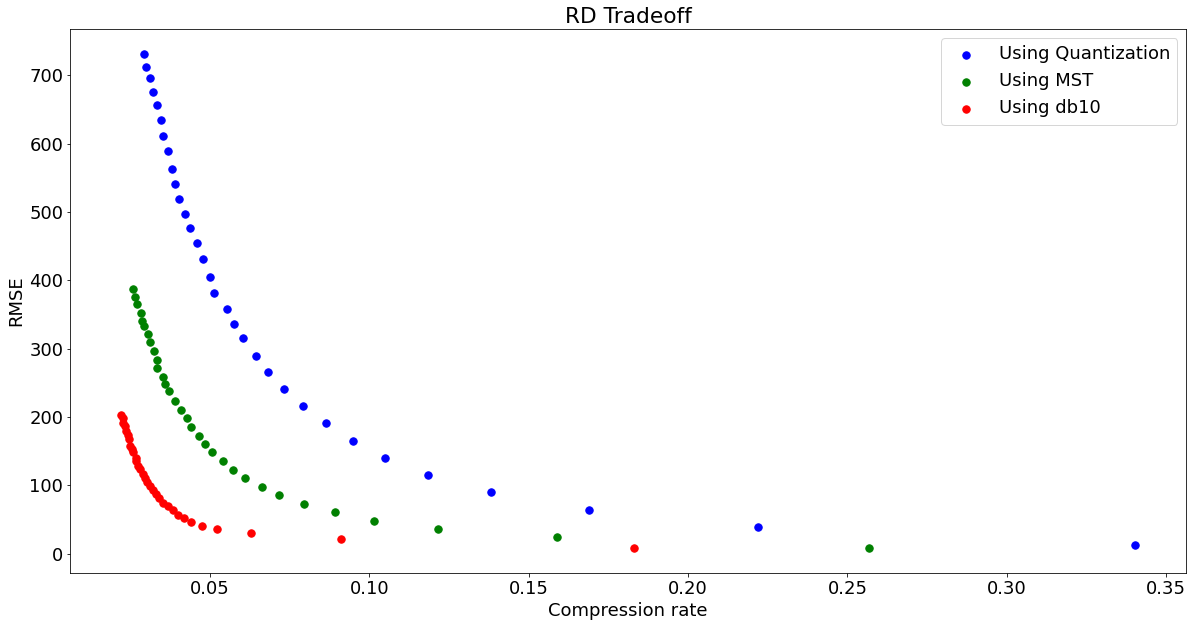

In [8]:
# Pintamos solo para una wavelet

just_a_wavelet = "db10"
level_wavelet = 2
frame_size = 1024
num_chunks = 10
#x=signal[frame_size*num_chunks:frame_size*(num_chunks+1)]

x=signal[frame_size*20:frame_size*40]

q_RD_points = q_RD_curve(x)
MST_RD_points = MST_RD_curve(x)
DWT_RD_points = DWT_RD_curve(x,level_wavelet,just_a_wavelet)

#Pintamos las curvas
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,10))
plt.title("RD Tradeoff")
plt.xlabel("Compression rate")
plt.ylabel("RMSE")
plt.scatter(*zip(*q_RD_points), c=colors[0], marker=".", label='Using Quantization', s=scatter_size)      
plt.scatter(*zip(*MST_RD_points), c=colors[1], marker=".", label='Using MST', s=scatter_size)          
plt.scatter(*zip(*DWT_RD_points), c=colors[2] , marker=".", label="Using " + just_a_wavelet, s=scatter_size)
plt.legend(loc='upper right')
plt.show()

# ¿Qué wavelet elegir?

La elección de una wavelet se basa en 3 factores:

1\. **Familia de la wavelet:** En pywt solo existen las familias: haar,  daebuchies, symlet, coiflets, biorthogonal y reverse biorthogonal.


2\. **Número de la wavelet:** Afecta a la respuesta y sobre todo al tamaño del filtro (a mayor tamaño, mayor longiud de filtro)

3\. **Nivel de descomposicion:** A mayor descomposicion, mejor es la compresión (en general), pero aumenta el consumo de CPU.

Aumentar el número y el nivel de descomposicion puede ayudar a mejorar la compresión, pero incrementa notoriamente el gasto computacional (el 50% de la ejecución o más puede emplearse en el calculo de la DWT).




# Comparativa de wavelets

Vamos a comprobar distintos tipos de wavelets 


In [9]:
def all_DWT_RD_curves(data, wavelets, level):
    List_RD_points = []
    for value in wavelets:
        lista=[]
        wavelet_name=value
        wavelet = pywt.Wavelet(wavelet_name)
        for q_step in range(16, 1024, 32):
            MST_coefs_pre = MST_analyze(data)
            DWT_coefs, slices = DWT_analyze(MST_coefs_pre, level, wavelet_name)
            k, y = q_deq(DWT_coefs, q_step)
            rate =  (len(compress(k))*8) / (len(data)*64)
            MST_coefs = DWT_synthesize(y, slices, wavelet_name=wavelet_name)
            reconstructed_data = MST_synthesize(MST_coefs)
            distortion = RMSE(data, reconstructed_data)
            lista.append((rate, distortion))
        List_RD_points.append(lista)
    return List_RD_points

def all_DWT_RD_curves(data, wavelets, level):
    List_RD_points = []
    for value in wavelets:
        lista=[]
        wavelet_name=value
        wavelet = pywt.Wavelet(wavelet_name)
        level = level
        try:
            level = wavelets[value]
        except:
            pass
        for q_step in range(16, 1024, 32):
            rate = 0
            distortion = 0
            MST_coefs_pre = MST_analyze(data)
            DWT_coefs, slices = DWT_analyze(MST_coefs_pre, level, wavelet_name)
            k, y = q_deq(DWT_coefs, q_step)
            rate =  (len(compress(k))*8) / (len(data)*64)
            MST_coefs = DWT_synthesize(y, slices, wavelet_name=wavelet_name)
            reconstructed_data = MST_synthesize(MST_coefs)
            distortion = RMSE(data, reconstructed_data)
            lista.append((rate, distortion))
        List_RD_points.append(lista)
    return List_RD_points

def print_DWT(list_DWT_RD_points, DWT_names, MST=0, quant=0):
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(20,10))
    plt.title("RD Tradeoff")
    plt.xlabel("Compression rate")
    plt.ylabel("RMSE")
    if(quant):
        plt.scatter(*zip(*quant), c="#888888" , marker=".", label="Quantification",s=220)
    if(MST):
        plt.scatter(*zip(*MST), c="#F38D3C" , marker=".", label="MST",s=220)
    index = 0
    indexwave = 0
    
    for i in DWT_names:
        addtxt=""
        name = i
        try: 
            name += " " + str(DWT_names[i])
        except exception as e:
            print(e)
        plt.scatter(*zip(*list_DWT_RD_points[index]), c=colors[index] , marker=".", label=name ,s=220)
        index+=1
    plt.legend(loc='upper right')
    plt.show()

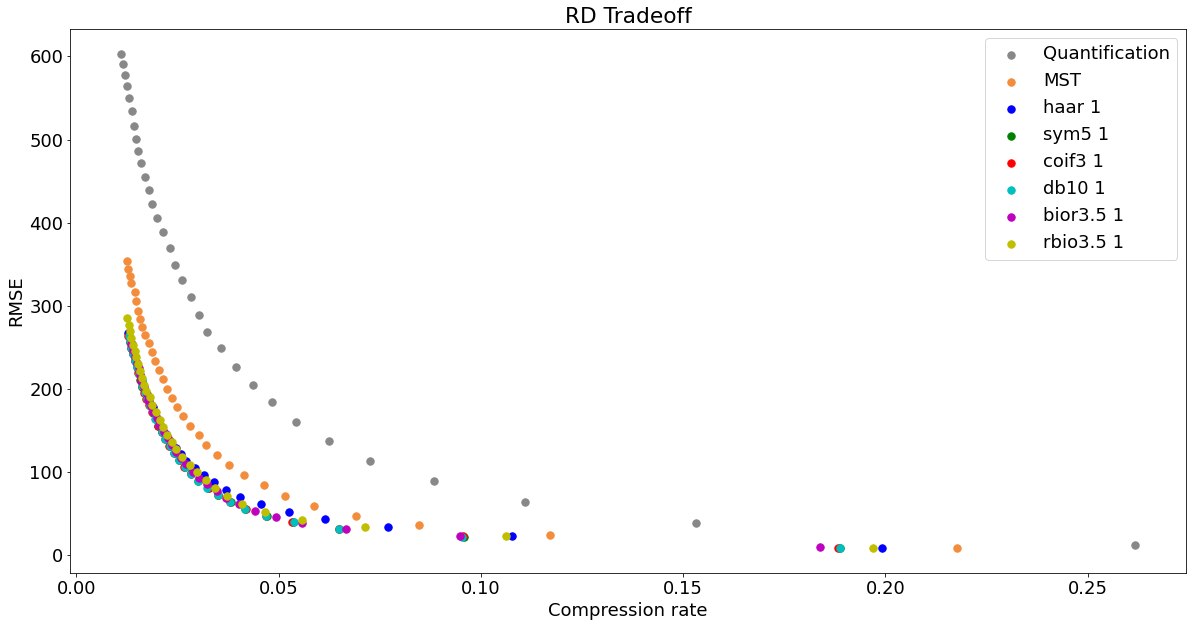

In [14]:
wavelets=["haar","sym5","bior2.2","rbio2.2"]

wavelet_representantes=["haar","db1","db10","bior1.1","rbio1.1"]

wavelets_dict={"haar":1, "sym5":1, "coif3":1, "db10":1, "bior3.5":1 , "rbio3.5":1}
colors=["b","g","r","c","m","y","k"]

#wavelets_dict ={"haar":1}#, "db1":1}

#level = 1
frame_size = 1024
init_chunk = 40
end_chunk = 80
x=signal[frame_size*init_chunk : frame_size*end_chunk]
list_quant = q_RD_curve(x)
list_MST = MST_RD_curve(x)
list_DWT_RD_points = all_DWT_RD_curves(x, wavelets_dict, level)
print_DWT(list_DWT_RD_points, wavelets_dict, list_MST, list_quant)

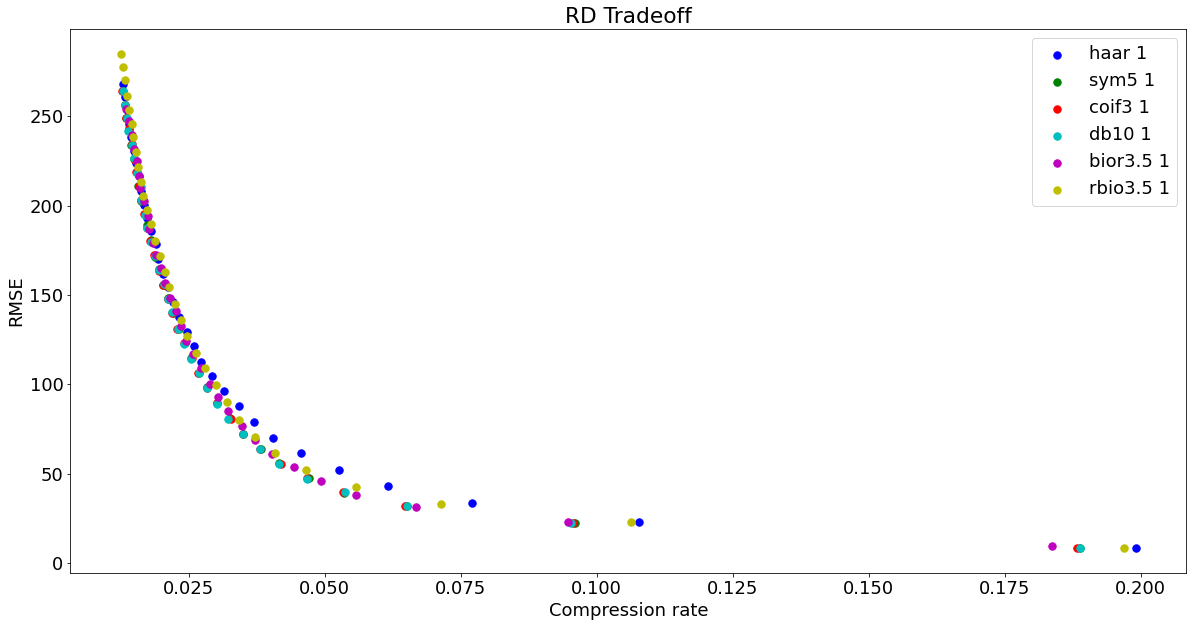

In [15]:
wavelets=["haar","sym5","bior2.2","rbio2.2"]

wavelet_representantes=["haar","db1","db10","bior1.1","rbio1.1"]

wavelets_dict={"haar":1, "sym5":1, "coif3":1, "db10":1, "bior3.5":1 , "rbio3.5":1}
colors=["b","g","r","c","m","y","k"]

#wavelets_dict ={"haar":1}#, "db1":1}

#level = 1
frame_size = 1024
init_chunk = 40
end_chunk = 80
x=signal[frame_size*init_chunk : frame_size*end_chunk]
list_quant = q_RD_curve(x)
list_MST = MST_RD_curve(x)
list_DWT_RD_points = all_DWT_RD_curves(x, wavelets_dict, level)
print_DWT(list_DWT_RD_points, wavelets_dict) # list_MST, list_quant)

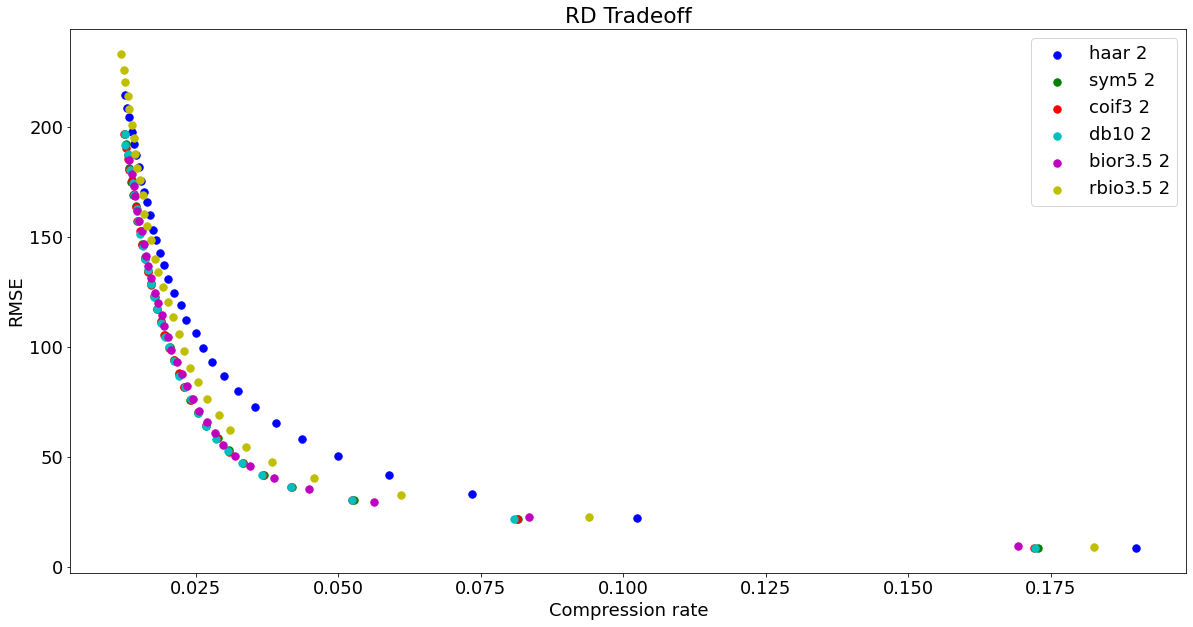

In [12]:
wavelets=["haar","sym5","bior2.2","rbio2.2"]

wavelet_representantes=["haar","db1","db10","bior1.1","rbio1.1"]

wavelets_dict={"haar":2, "sym5":2, "coif3":2, "db10":2, "bior3.5":2 , "rbio3.5":2}
colors=["b","g","r","c","m","y","k"]

#wavelets_dict ={"haar":1}#, "db1":1}

#level = 1
frame_size = 1024
init_chunk = 40
end_chunk = 80
x=signal[frame_size*init_chunk : frame_size*end_chunk]
list_quant = q_RD_curve(x)
list_MST = MST_RD_curve(x)
list_DWT_RD_points = all_DWT_RD_curves(x, wavelets_dict, level)
print_DWT(list_DWT_RD_points, wavelets_dict) # list_MST, list_quant)

# Solapamiento de chunks

Dado que se aplica la DWT a chunks sueltos, es posible que se produzcan efectos indeseados en los extremos. Para ver este efecto, se procede a capturar 3 chunks, aplicar y deshacer el procedimiento.


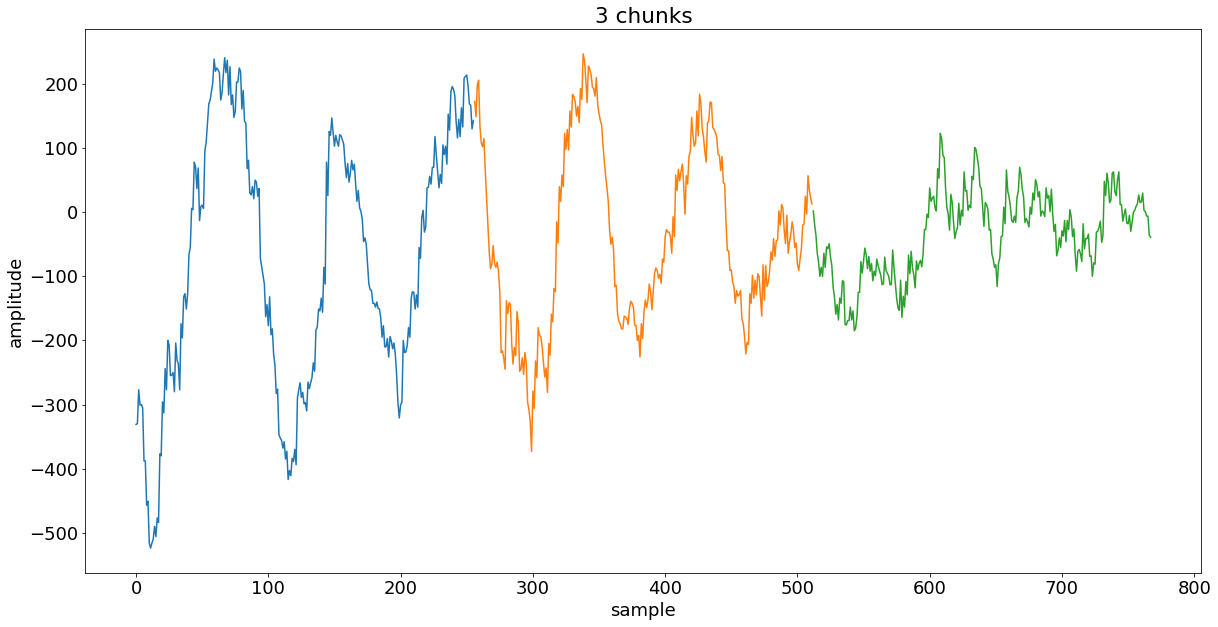

In [13]:
filters_name = "sym5"
wavelet = pywt.Wavelet(filters_name)
signal_mode_extension = "per"
quantization_step = 128
chunk_size = 256
chunk_number = 16
levels = 2
signal_flatten = signal.flatten()
left_chunk = signal_flatten[chunk_size * (chunk_number - 1) : chunk_size * chunk_number]
center_chunk = signal_flatten[chunk_size * chunk_number : chunk_size * (chunk_number + 1)]
right_chunk = signal_flatten[chunk_size * (chunk_number + 1) : chunk_size * (chunk_number + 2)]
chunks = np.concatenate([left_chunk, center_chunk, right_chunk])
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,10))
pylab.plot(np.linspace(0, len(left_chunk)-1, len(left_chunk)), left_chunk)
pylab.plot(np.linspace(len(left_chunk), len(left_chunk) + len(center_chunk) - 1, len(center_chunk)), center_chunk)
pylab.plot(np.linspace(len(left_chunk) + len(center_chunk), len(left_chunk) + len(center_chunk) + len(right_chunk) - 1, len(right_chunk)), right_chunk)
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("3 chunks")
pylab.show()

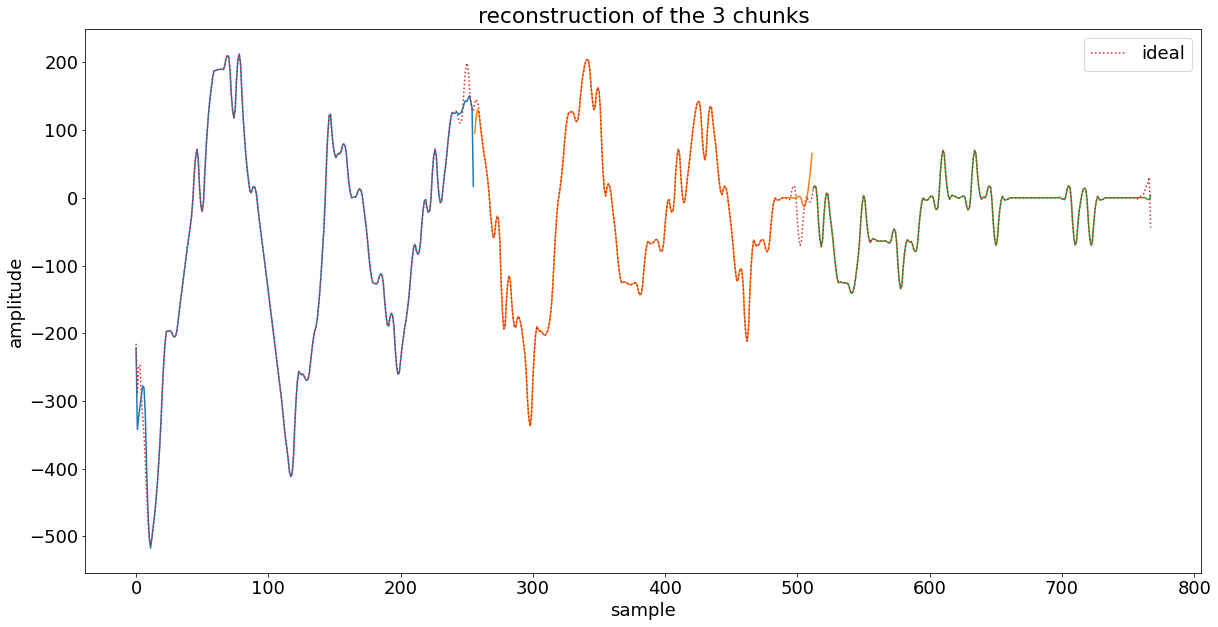

In [163]:
# Codigo para aplicar el procedimiento completo y deshacerlo
def transform_and_quantize(chunk):
    decomposition = pywt.wavedec(chunk, wavelet=wavelet, level=levels, mode=signal_mode_extension)
    quantized_decomposition = []
    for subband in decomposition:
        quantized_subband = quantizer(subband, quantization_step)
        quantized_decomposition.append(quantized_subband)
    return quantized_decomposition
    
def dequantize_and_detransform(decomposition):
    dequantized_decomposition = []
    for subband in decomposition:
        dequantized_subband = dequantizer(subband, quantization_step)
        dequantized_decomposition.append(dequantized_subband)
    chunk = pywt.waverec(dequantized_decomposition, wavelet=wavelet, mode=signal_mode_extension)
    return chunk

def reconstruct_chunk(chunk):
    quantization_indexes = transform_and_quantize(chunk)
    reconstructed_chunk = dequantize_and_detransform(quantization_indexes)
    return reconstructed_chunk
    
reconstructed_left_chunk = reconstruct_chunk(left_chunk)
reconstructed_center_chunk = reconstruct_chunk(center_chunk)
reconstructed_right_chunk = reconstruct_chunk(right_chunk)
ideal_chunks_reconstruction = reconstruct_chunk(chunks)
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,10))
pylab.plot(np.linspace(0, len(reconstructed_left_chunk)-1, len(reconstructed_left_chunk)), reconstructed_left_chunk)
pylab.plot(np.linspace(len(reconstructed_left_chunk), len(reconstructed_left_chunk) + len(reconstructed_center_chunk) - 1, len(reconstructed_center_chunk)), reconstructed_center_chunk)
pylab.plot(np.linspace(len(reconstructed_left_chunk) + len(reconstructed_center_chunk), len(reconstructed_left_chunk) + len(reconstructed_center_chunk) + len(reconstructed_right_chunk) - 1, len(reconstructed_right_chunk)), reconstructed_right_chunk)
pylab.plot(np.linspace(0, len(ideal_chunks_reconstruction)-1, len(ideal_chunks_reconstruction)), ideal_chunks_reconstruction, linestyle='dotted', label="ideal")
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("reconstruction of the 3 chunks")
pylab.legend(loc='upper right')
pylab.show()


#np.concatenate([reconstructed_left_chunk, reconstructed_center_chunk, reconstructed_right_chunk])

Vamos a recortar un poco la gráfica para visualizar mejor los errores de solapamiento 

768


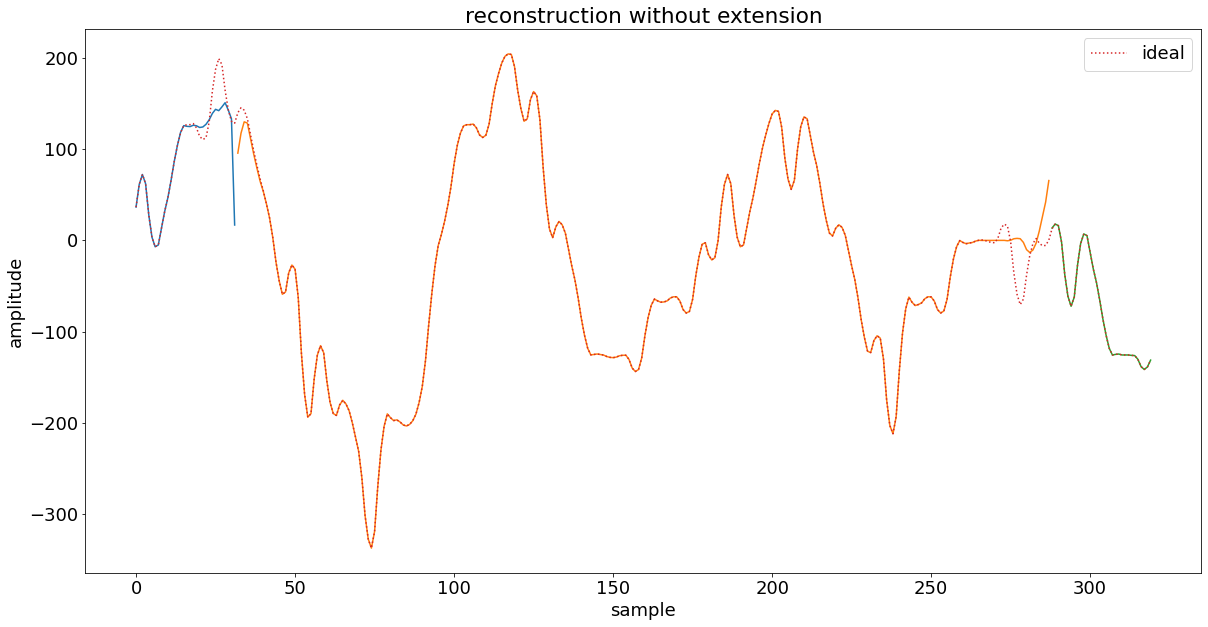

In [204]:
reconstructed_left_chunk = reconstruct_chunk(left_chunk)
reconstructed_center_chunk = reconstruct_chunk(center_chunk)
reconstructed_right_chunk = reconstruct_chunk(right_chunk)
reconstructed_left_chunk = reconstructed_left_chunk[len(reconstructed_left_chunk)-number_of_overlaped_samples:]
reconstructed_center_chunk = reconstruct_chunk(center_chunk)
reconstructed_right_chunk = reconstruct_chunk(right_chunk)
reconstructed_right_chunk = reconstructed_right_chunk[:number_of_overlaped_samples]
ideal_chunks_reconstruction2 = reconstruct_chunk(chunks)
ideal_chunks_reconstruction2 = ideal_chunks_reconstruction[len(reconstructed_center_chunk)-number_of_overlaped_samples : len(reconstructed_center_chunk)*2+number_of_overlaped_samples]
print(len(ideal_chunks_reconstruction))
plt.rcParams.update({'font.size': 18})
figure=plt.figure(figsize=(20,10))
pylab.plot(np.linspace(0, len(reconstructed_left_chunk)-1, len(reconstructed_left_chunk)), reconstructed_left_chunk)
pylab.plot(np.linspace(len(reconstructed_left_chunk), len(reconstructed_left_chunk) + len(reconstructed_center_chunk) - 1, len(reconstructed_center_chunk)), reconstructed_center_chunk)
pylab.plot(np.linspace(len(reconstructed_left_chunk) + len(reconstructed_center_chunk), len(reconstructed_left_chunk) + len(reconstructed_center_chunk) + len(reconstructed_right_chunk) - 1, len(reconstructed_right_chunk)), reconstructed_right_chunk)
pylab.plot(np.linspace(0, len(ideal_chunks_reconstruction2)-1, len(ideal_chunks_reconstruction2)), ideal_chunks_reconstruction2, linestyle='dotted', label="ideal")
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("reconstruction without extension")
pylab.legend(loc='upper right')
pylab.show()

#rm reconstruct_no_extended.pdf reconstruct_no_extended.svg
figure.savefig('reconstruct_no_extended.pdf')
!pdf2svg reconstruct_no_extended.pdf reconstruct_no_extended.svg
!rsvg-convert -a -w 1100 -f svg reconstruct_no_extended.svg -o reconstruct_no_extended2.svg

## Solución de los gaps y divergencias

La solución de los efectos indeseados se puede lograr extendiendo parcialmente el chunk en cuestión. La pregunta es ¿cuánto se debe extender? Para responder a esta pregunta, se debe tener en cuenta la longitud del filtro. La siguiente fórmula nos indica cuanto debe extenderse (en conjunto)el chunk en cuestión.

In [273]:
number_of_overlaped_samples = 1 << math.ceil(math.log(wavelet.dec_len * levels) / math.log(2))
print("Número adicionales totales de frames por cada lado: ", number_of_overlaped_samples)

Número adicionales totales de frames por cada lado:  32


Mediante el siguiente código, se construye un chunk extendido y se aplica el procedimiento.

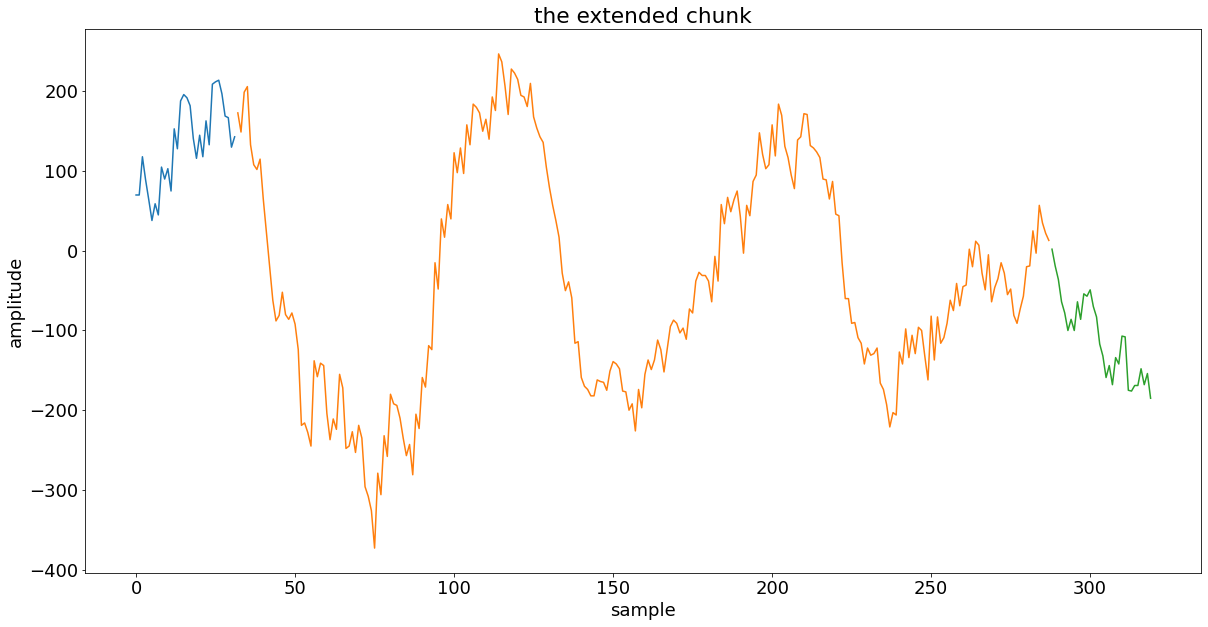

In [274]:
wavelet = pywt.Wavelet(filters_name)
number_of_overlaped_samples = 1 << math.ceil(math.log(wavelet.dec_len * levels) / math.log(2))
last_samples_left_chunk = left_chunk[chunk_size - number_of_overlaped_samples :]
first_samples_right_chunk = right_chunk[: number_of_overlaped_samples]
extended_chunk = np.concatenate([last_samples_left_chunk, center_chunk, first_samples_right_chunk])
plt.rcParams.update({'font.size': 18})
figure=plt.figure(figsize=(20,10))
pylab.plot(np.linspace(0,
                       len(last_samples_left_chunk)-1,
                       len(last_samples_left_chunk)),
           last_samples_left_chunk)
pylab.plot(np.linspace(len(last_samples_left_chunk),
                       len(last_samples_left_chunk) + len(center_chunk) - 1,
                       len(center_chunk)),
           center_chunk)
pylab.plot(np.linspace(len(last_samples_left_chunk) + len(center_chunk),
                       len(last_samples_left_chunk) + len(center_chunk) + len(first_samples_right_chunk) - 1,
                       len(first_samples_right_chunk)),
           first_samples_right_chunk)
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("the extended chunk")
pylab.show()

figure.savefig('extended.pdf')
!pdf2svg extended2.pdf extended.svg
!rsvg-convert -a -w 1100 -f svg extended.svg -o extended2.svg

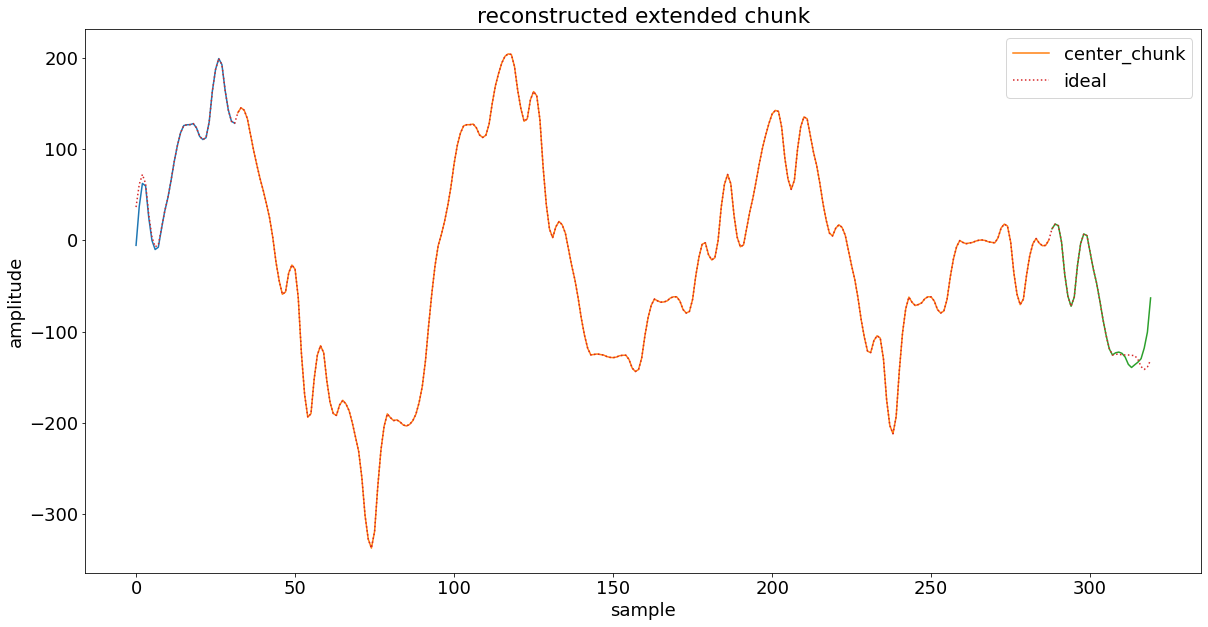

In [275]:
reconstructed_extended_chunk = reconstruct_chunk(extended_chunk)
reconstructed_last_samples_left_chunk = reconstructed_extended_chunk[0:number_of_overlaped_samples]
reconstructed_center_chunk = reconstructed_extended_chunk[number_of_overlaped_samples:chunk_size + number_of_overlaped_samples]
reconstructed_first_samples_right_chunk = reconstructed_extended_chunk[chunk_size + number_of_overlaped_samples:]
ideal_reconstruction = ideal_chunks_reconstruction[
    chunk_size - number_of_overlaped_samples:
    2*chunk_size + number_of_overlaped_samples]
plt.rcParams.update({'font.size': 18})
figure = plt.figure(figsize=(20,10))
pylab.plot(np.linspace(0,
                       len(reconstructed_last_samples_left_chunk)-1,
                       len(reconstructed_last_samples_left_chunk)),
           reconstructed_last_samples_left_chunk)
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk) - 1,
                       len(reconstructed_center_chunk)),
           reconstructed_center_chunk, label="center_chunk")
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk) + len(reconstructed_first_samples_right_chunk) - 1,
                       len(reconstructed_first_samples_right_chunk)),
           reconstructed_first_samples_right_chunk)
pylab.plot(np.linspace(0,
                       len(ideal_reconstruction)-1,
                       len(ideal_reconstruction)),
           ideal_reconstruction, linestyle='dotted', label="ideal")
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("reconstructed extended chunk")
pylab.legend(loc='upper right')
pylab.show()

figure.savefig('reconstructed_extend.pdf')
!pdf2svg reconstructed_extend.pdf reconstruct_extended.svg
!rsvg-convert -a -w 1100 -f svg reconstruct_extended.svg -o reconstruct_extended2.svg

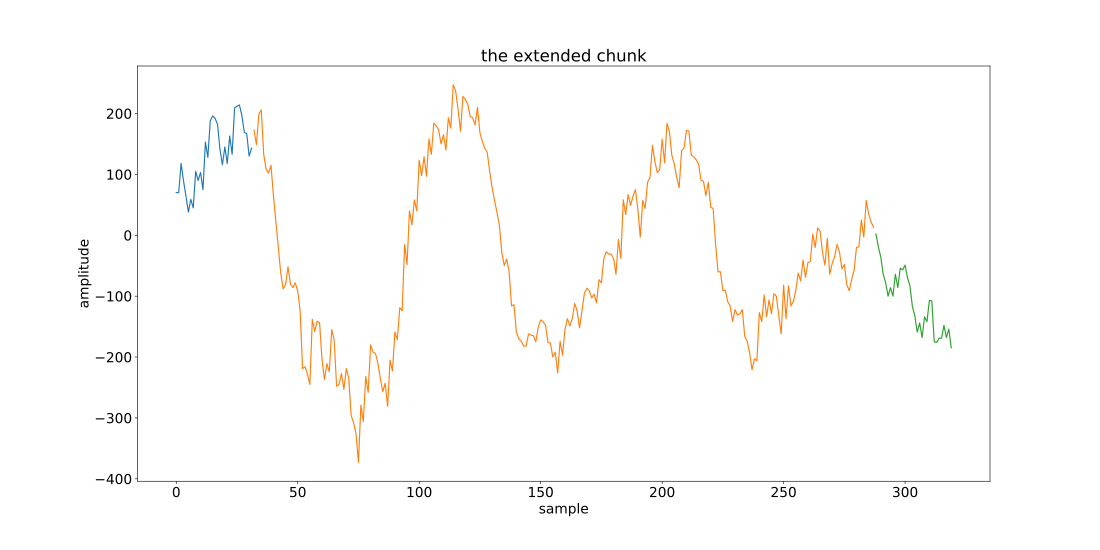

In [214]:
from IPython.core.display import SVG
SVG(filename='extended2.svg')

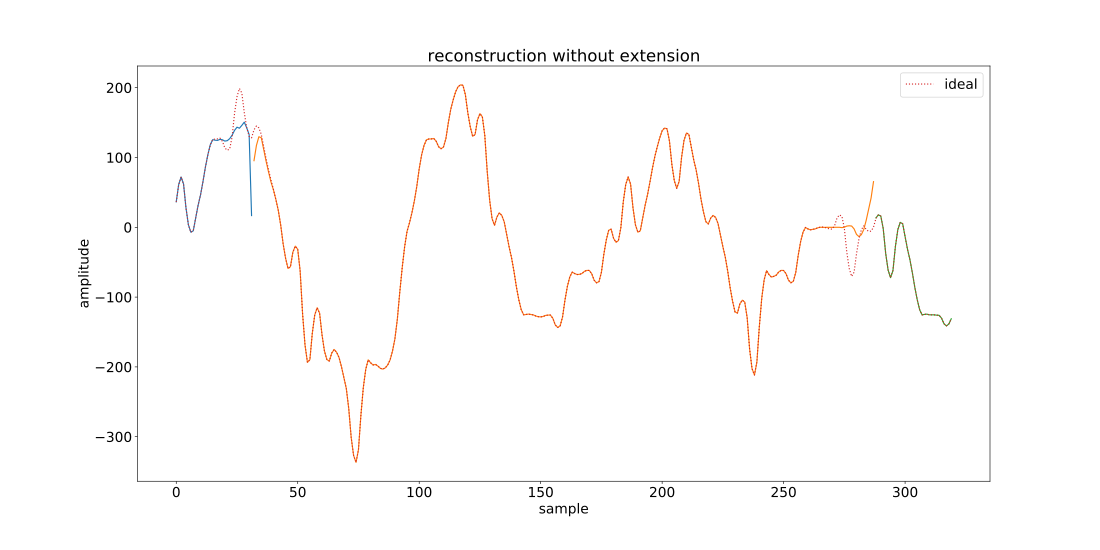

In [215]:
SVG(filename='reconstruct_no_extended2.svg')

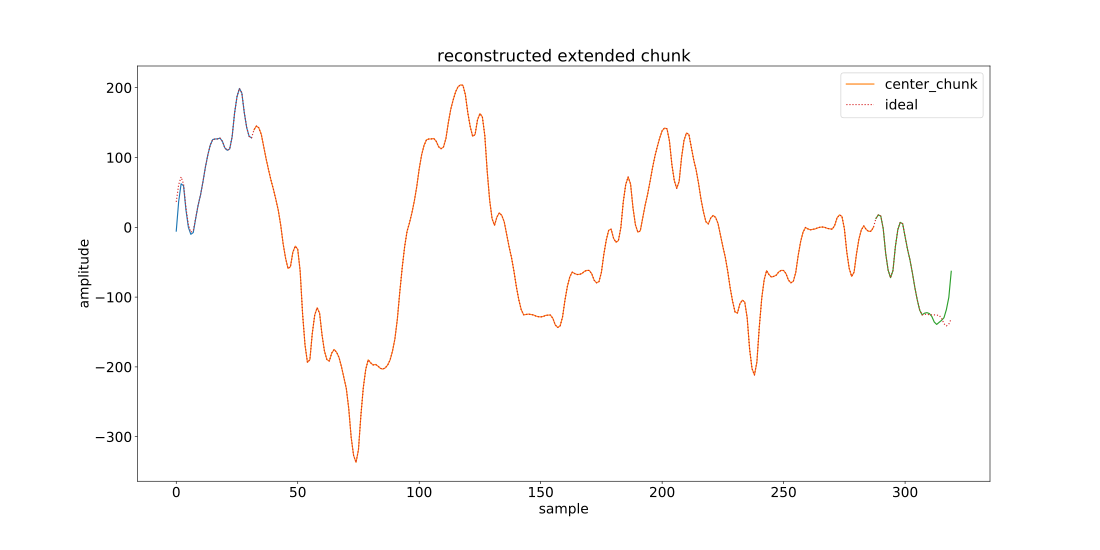

In [216]:
SVG(filename='reconstruct_extended2.svg')

## Problema de compresión

Se ha visto que aumentar el nivel de una wavelet ayuda a mejorar la compresión. Sin embargo, si pretendemos resolver el problema de solapamiento, resulta necesario ampliar una cierta cantidad el tamaño del chunk. Este aumento puede comprometer la compresión. A continuación se muestra el número de muestras que deben añadirse al chunk para generar la ampliación en virtud de la wavelet y del nivel de descomposición.

In [14]:
wavelets_dict={"haar":3, "sym5":3, "coif3":3, "db10":3, "bior2.2":3 , "bior3.5":3, "db20":4}
def get_overlaped_samples(wavelet_dict):
    for i in wavelet_dict:
        wavelet = pywt.Wavelet(i)
        number_of_overlaped_samples = 1 << math.ceil(math.log(wavelet.dec_len * wavelet_dict[i]) / math.log(2))
        print("------------------------")
        print("Nombre de wavelet:", i, )
        print("Nivel de descomposición:", wavelet_dict[i])
        print("Número de muestras adicionales:", number_of_overlaped_samples*2)

get_overlaped_samples(wavelets_dict)

------------------------
Nombre de wavelet: haar
Nivel de descomposición: 3
Número de muestras adicionales: 16
------------------------
Nombre de wavelet: sym5
Nivel de descomposición: 3
Número de muestras adicionales: 64
------------------------
Nombre de wavelet: coif3
Nivel de descomposición: 3
Número de muestras adicionales: 128
------------------------
Nombre de wavelet: db10
Nivel de descomposición: 3
Número de muestras adicionales: 128
------------------------
Nombre de wavelet: bior2.2
Nivel de descomposición: 3
Número de muestras adicionales: 64
------------------------
Nombre de wavelet: bior3.5
Nivel de descomposición: 3
Número de muestras adicionales: 128
------------------------
Nombre de wavelet: db20
Nivel de descomposición: 4
Número de muestras adicionales: 512


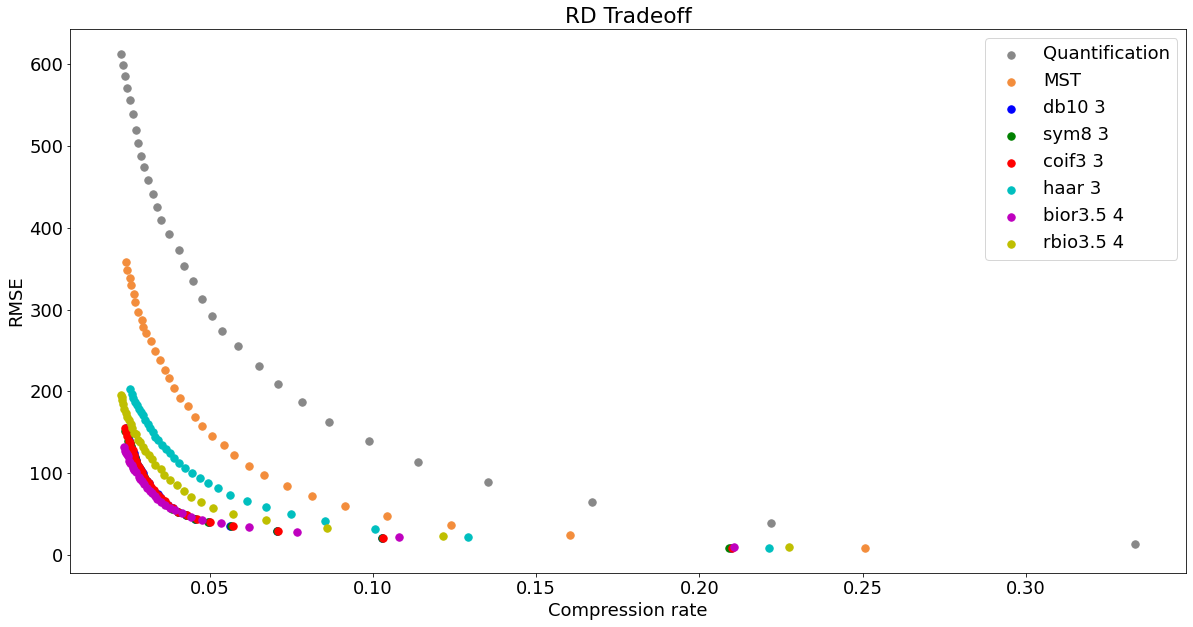

In [13]:
def q_RD_curve_chunks(data, chunk_size=1024):
    RD_points = []
    num_chunks = int(len(data)/1024)
    for q_step in range(16, 1024, 32):
        rate = 0
        distortion = 0
        for i in range(0, num_chunks):
            current_chunk = data[chunk_size*i:chunk_size*(i+1)]
            k, y = q_deq(current_chunk, q_step)
            compressed = compress(k)
            rate +=  (len(compressed)*8) / (len(current_chunk)*64)
            distortion += RMSE(current_chunk, y)
        RD_points.append((rate/num_chunks, distortion/num_chunks))
    return RD_points


def MST_RD_curve_chunks(data, chunk_size=1024):
    RD_points = []
    num_chunks = int(len(data)/1024)
    for q_step in range(16, 1024, 32):
        rate = 0
        distortion = 0
        for i in range(0, num_chunks):
            current_chunk = data[chunk_size*i:chunk_size*(i+1)]
            analyzed_data = MST_analyze(current_chunk)
            k, y = q_deq(analyzed_data, q_step)
            compressed = compress(k)
            rate += (len(compressed)*8) / (len(current_chunk)*64)
            reconstructed_data = MST_synthesize(y)
            distortion += RMSE(current_chunk, reconstructed_data)
        RD_points.append((rate/num_chunks, distortion/num_chunks))
    return RD_points


def all_DWT_RD_curves_chunks(data, wavelets, level, chunk_size=1024):
    List_RD_points = []
    num_chunks = int(len(data)/1024)
    for value in wavelets:
        lista=[]
        wavelet_name = value
        wavelet = pywt.Wavelet(wavelet_name)
        level = 1
        try:
            level = wavelets[value]
        except:
            pass
        number_of_overlaped_samples = 1 << math.ceil(math.log(wavelet.dec_len * level) / math.log(2))
        for q_step in range(16, 1024, 32):
            rate = 0
            distortion = 0
            chunk_central = np.zeros((1024, 2), dtype=np.int32)
            chunk_izda = np.zeros((1024, 2), dtype=np.int32)
            chunk_dcha = np.zeros((1024, 2), dtype=np.int32)
            for i in range(0, num_chunks):
                current_chunk = data[chunk_size*i:chunk_size*(i+1)]
                chunk_izda = chunk_central
                chunk_central = chunk_dcha
                chunk_dcha = current_chunk
                parte_izda = chunk_izda[len(chunk_izda)-number_of_overlaped_samples:]
                parte_dcha = chunk_dcha[:number_of_overlaped_samples]
                chunk_extendido = np.concatenate([parte_izda, chunk_central, parte_dcha])
                MST_coefs_pre = MST_analyze(chunk_extendido)
                DWT_coefs, slices = DWT_analyze(MST_coefs_pre, level, wavelet_name)
                k, y = q_deq(DWT_coefs, q_step)
                rate +=  (len(compress(k))*8) / (len(current_chunk)*64)
                MST_coefs = DWT_synthesize(y, slices, wavelet_name=wavelet_name)
                reconstructed_data = MST_synthesize(MST_coefs)
                distortion += RMSE(chunk_extendido, reconstructed_data)
            lista.append((rate/num_chunks, distortion/num_chunks))
        List_RD_points.append(lista)
    return List_RD_points


wavelets=["haar","sym5","bior2.2","rbio2.2"]

wavelet_representantes=["haar","db1","db10","bior1.1","rbio1.1"]

wavelets_dict={"db10":3, "sym8":3, "coif3":3, "haar":3, "bior3.5":4, "bior3.5":4 , "rbio3.5":4}
colors=["b","g","r","c","m","y","k"]


#wavelets_dict={"db20":4, "sym5":3, "sym8":3}# "sym20":4}
#wavelets_dict={"sym8":3}
level = 3
frame_size = 1024
init_chunk = 40
end_chunk = 60
x=signal[frame_size*init_chunk : frame_size*end_chunk]
list_quant = q_RD_curve_chunks(x)
list_MST = MST_RD_curve_chunks(x)
list_DWT_RD_points = all_DWT_RD_curves_chunks(x, wavelets_dict, level)
print_DWT(list_DWT_RD_points, wavelets_dict, list_MST, list_quant) #DWT_RD_points #list_MST

# Desfase temporal

Para solucionar el problema del overlapping. Se produce una extensión del chunk hacia ambos lados, por tanto, es necesario contar con los dos.

El problema se presenta con el chunk de la derecha, el cual se corresponde con un instante en el futuro. La solución más elemental consiste en "retrasar" el envío un chunk, de forma que. Esto quiere decir que cuando recibimos un chunk:

1\.  El vector de la derecha pasa al vector central y el central a la posición izquierda.

2\. Colocamos el chunk grabado en el vector derecha.

3\. Se Procesa el chunk central (grabado en el instante anterior) y se envía.

4\. Se Repite el paso 1 al terminar de grabar el siguiente chunk.


La implementación consiste en los siguientes pasos:

1\. **Creación e inicialización de los 3 chunks:**
``` Python
self.central_chunk = np.zeros(shape=(minimal.args.frames_per_chunk, minimal.Minimal.NUMBER_OF_CHANNELS),
                              dtype=np.int16)
self.left_chunk = np.zeros(shape=(minimal.args.frames_per_chunk, minimal.Minimal.NUMBER_OF_CHANNELS),
                           dtype=np.int16)
self.right_chunk = np.zeros(shape=(minimal.args.frames_per_chunk, minimal.Minimal.NUMBER_OF_CHANNELS),
                            dtype=np.int16)
```

2\. **Intercambio de vectores al empaquetar:** 

``` Python
self.left_chunk = self.central_chunk
self.central_chunk = self.right_chunk
self.right_chunk = chunk
```

3\. **Generación de chunk extendido:**

``` Python
left_samples = self.left_chunk[len(chunk) - self.wavelet.number_of_overlapped_samples:]
right_samples = self.right_chunk[: self.wavelet.number_of_overlapped_samples]
extended_chunk = np.concatenate([left_samples, self.central_chunk, right_samples])
```

4\. **Aplicación de MST y DWT:**

``` Python
extended_chunk = self.analyze(extended_chunk)
extended_chunk, self.slice_send = self.DWT_analyze(extended_chunk, self.wavelet.level, 
                                                   self.wavelet.wavelet_name)
```
 

# Elección de wavelet

El aumento de número y nivel de wavelet ayuda en principio a mejorar la tasa de compresión y la calidad del audio. Sin embargo, en primer lugar se compromete el consumo de CPU y en segundo lugar, la solución del solapamiento puede perjudicar la compresión debido al aumento de 

Si se tuviera que elegir el criterio de elección sería:

- **Nivel de descomposición:** entre 2 y 3 (salvo envío de slices). Si el consumo de CPU no es problema, entonces se debe elegir el nivel 4 de descomposición.
- **Wavelets:** sym5, db10 y bior3.5 (aunque hay otros candidatos).